# Anomaly Detection with pyOD

This notebook demonstrates anomaly detection using `pyod` on univariate and multivariate examples. It includes installs (Colab), synthetic data generation, fitting multiple detectors (IForest, LOF, HBOS, AutoEncoder), evaluation (ROC-AUC, precision@k), and visualization.

# Install notes (uncomment in Colab)
# !pip install pyod matplotlib seaborn scikit-learn

print('If running in Colab, uncomment pip installs and restart runtime if needed')

In [7]:
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.3/46.3 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 204.7/204.7 kB 7.6 MB/s eta 0:00:00


In [8]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

sns.set()

PYOD_AVAILABLE = False
try:
    from pyod.models.iforest import IForest
    from pyod.models.lof import LOF
    from pyod.models.hbos import HBOS
    from pyod.models.auto_encoder import AutoEncoder
    PYOD_AVAILABLE = True
    print('pyod imported successfully')
except ImportError as e:
    print('pyod not available. Install it with: !pip install pyod')
    print('Error:', e)

print('Imports ready')

pyod imported successfully
Imports ready


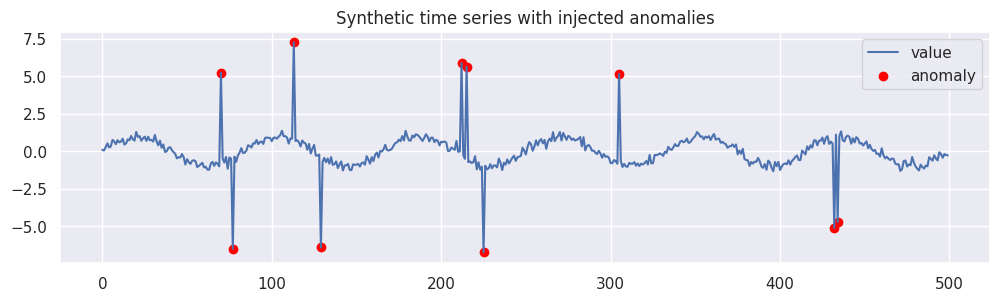

In [9]:
# Generate univariate synthetic time-series with injected anomalies
np.random.seed(42)
T = 500
x = np.sin(np.linspace(0, 12*np.pi, T)) + 0.2*np.random.randn(T)
# inject spikes
anomaly_idx = np.random.choice(np.arange(50,450), size=10, replace=False)
x[anomaly_idx] += np.random.choice([6, -6], size=len(anomaly_idx))

df_ts = pd.DataFrame({'x': x})

def plot_ts_with_anomalies(series, anomalies=None, title=''):
    plt.figure(figsize=(12,3))
    plt.plot(series, label='value')
    if anomalies is not None:
        plt.scatter(anomalies, series[anomalies], color='red', label='anomaly')
    plt.title(title)
    plt.legend()
    plt.show()

plot_ts_with_anomalies(df_ts['x'], anomalies=anomaly_idx, title='Synthetic time series with injected anomalies')


IForest AUC: 1.0000
LOF AUC: 1.0000
HBOS AUC: 1.0000


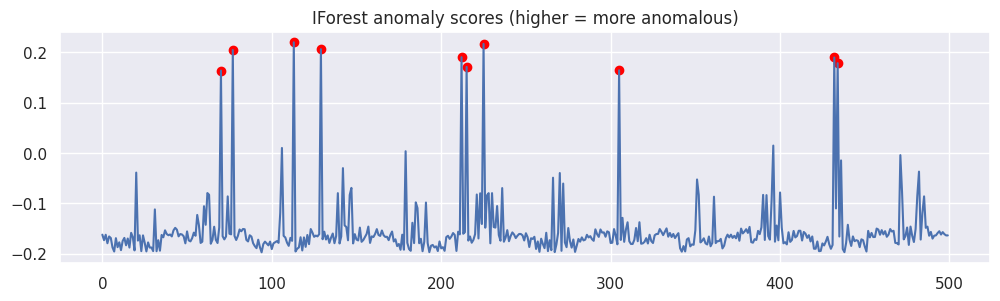

In [10]:
# Fit multiple detectors (univariate) and evaluate
# We'll reshape to (n_samples, n_features)
X_uni = df_ts['x'].values.reshape(-1,1)

if not PYOD_AVAILABLE:
    raise ImportError("pyod is not installed. Run: !pip install pyod  then restart the runtime and re-run all cells.")

models = {
    'IForest': IForest(contamination=0.025),
    'LOF': LOF(contamination=0.025),
    'HBOS': HBOS(contamination=0.025),
}

results = {}
for name, model in models.items():
    try:
        model.fit(X_uni)
        scores = model.decision_scores_  # higher -> more abnormal
        # compute AUC against ground-truth anomaly_idx
        y_true = np.zeros(len(X_uni), dtype=int)
        y_true[anomaly_idx] = 1
        try:
            auc_score = roc_auc_score(y_true, scores)
        except Exception:
            auc_score = np.nan
        results[name] = {'scores': scores, 'auc': auc_score}
        print(f'{name} AUC: {auc_score:.4f}')
    except Exception as e:
        print(f'Error fitting {name}:', e)

# Plot scores for IForest as example
if 'IForest' in results:
    plt.figure(figsize=(12,3))
    plt.plot(results['IForest']['scores'], label='IForest score')
    plt.scatter(anomaly_idx, results['IForest']['scores'][anomaly_idx], color='red')
    plt.title('IForest anomaly scores (higher = more anomalous)')
    plt.show()